# Greatest Hits Guidance

In [1]:
import numpy as np
import os, sys, json
import matplotlib.pyplot
import matplotlib.pyplot as plt
import librosa, librosa.display
import torch
import IPython
from IPython.display import Audio, display
import pickle
import urllib.request


from tifresi.utils import preprocess_signal

import sys
sys.path.insert(0, '../')
import dnnlib
from utils import util, training_utils, losses, masking, gaver_sounds, perceptual_guidance
from networks import stylegan_encoder

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

/home/purnima/anaconda3/envs/audio-latent-composition/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/purnima/anaconda3/envs/audio-latent-composition/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
sample_rate = 16000
stft_channels = 512
n_frames = 256
hop_size = 128

pghi_min = -50.0
pghi_max = 0.0

np.random.seed(123)

device = torch.device('cuda')

In [3]:
stylegan_pkl = "../checkpoints/stylegan2/greatesthits/network-snapshot-002800.pkl"
encoder_pkl = "../checkpoints/encoder/greatesthits/netE_epoch_best.pth"

stylegan_pkl_url = "https://guided-control-by-prototypes.s3.ap-southeast-1.amazonaws.com/resources/model_weights/audio-stylegan2/greatesthits/network-snapshot-002800.pkl"
encoder_pkl_url = "https://guided-control-by-prototypes.s3.ap-southeast-1.amazonaws.com/resources/model_weights/encoder/greatesthits/netE_epoch_best.pth"

if not os.path.isfile(stylegan_pkl):
    os.makedirs("../checkpoints/stylegan2/greatesthits/", exist_ok=True)
    urllib.request.urlretrieve(stylegan_pkl_url, stylegan_pkl)

if not os.path.isfile(encoder_pkl):
    os.makedirs("../checkpoints/encoder/greatesthits/", exist_ok=True)
    urllib.request.urlretrieve(encoder_pkl_url, encoder_pkl)

In [4]:
with open(stylegan_pkl, 'rb') as pklfile:
    network = pickle.load(pklfile)
    G = network['G'].to(device).eval()
    
netE = stylegan_encoder.load_stylegan_encoder(domain=None, nz=G.z_dim,
                                                   outdim=128,
                                                   use_RGBM=True,
                                                   use_VAE=False,
                                                   resnet_depth=34,
                                                   ckpt_path=encoder_pkl)
netE = netE.to(device).eval()

Using halfsize?: False
Input channels: 2


In [5]:
def reconstruct(encoded):
    reconstructed_audio = G.synthesis(torch.stack([encoded] * 14, dim=1))
    filler = torch.full((1, 1, 1, reconstructed_audio[0].shape[1]), torch.min(reconstructed_audio)).cuda()
    reconstructed_audio = torch.cat([reconstructed_audio, filler], dim=2)
    reconstructed_audio = util.renormalize(reconstructed_audio, (torch.min(reconstructed_audio), torch.max(reconstructed_audio)), (pghi_min, pghi_max))
    reconstructed_audio = reconstructed_audio.detach().cpu().numpy()[0]
    reconstructed_audio_wav = util.pghi_istft(reconstructed_audio, hop_size=hop_size, stft_channels=stft_channels)
    return reconstructed_audio_wav

def random_sample():
    z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
    reconstructed_audio = G(z, None)
    filler = torch.full((1, 1, 1, reconstructed_audio[0].shape[1]), torch.min(reconstructed_audio)).cuda()
    reconstructed_audio = torch.cat([reconstructed_audio, filler], dim=2)
    reconstructed_audio = util.renormalize(reconstructed_audio, (torch.min(reconstructed_audio), torch.max(reconstructed_audio)), (pghi_min, pghi_max))
    reconstructed_audio = reconstructed_audio.detach().cpu().numpy()[0]
    reconstructed_audio_wav = util.pghi_istft(reconstructed_audio, hop_size=hop_size, stft_channels=stft_channels)
    return reconstructed_audio_wav

def encode_and_reconstruct(audio):
    audio_pghi = preprocess_signal(audio)
    audio_pghi = util.zeropad(audio_pghi, n_frames * hop_size )
    audio_pghi = util.pghi_stft(audio_pghi, hop_size=hop_size, stft_channels=stft_channels)
    audio_pghi = util.renormalize(audio_pghi, (np.min(audio_pghi), np.max(audio_pghi)), (im_min, im_max))

    audio_pghi = torch.from_numpy(audio_pghi).float().cuda().unsqueeze(dim=0)
    mask = torch.ones_like(audio_pghi)[:, :1, :, :]
    net_input = torch.cat([audio_pghi, mask], dim=1).cuda()
    
    with torch.no_grad():
        encoded = netE(net_input)

    reconstructed_audio = G.synthesis(torch.stack([encoded] * 14, dim=1))
    filler = torch.full((1, 1, 1, reconstructed_audio[0].shape[1]), torch.min(reconstructed_audio)).cuda()
    reconstructed_audio = torch.cat([reconstructed_audio, filler], dim=2)
    reconstructed_audio = util.renormalize(reconstructed_audio, (torch.min(reconstructed_audio), torch.max(reconstructed_audio)), (pghi_min, pghi_max))
    reconstructed_audio = reconstructed_audio.detach().cpu().numpy()[0]
    reconstructed_audio_wav = util.pghi_istft(reconstructed_audio, hop_size=hop_size, stft_channels=stft_channels)
    
    return encoded, reconstructed_audio_wav

In [6]:
z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
im = G(z, None)
im_min = torch.min(im).cpu().numpy()
im_max = torch.max(im).cpu().numpy()
print(im_min, im_max)

Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
-1.05056 1.0142103


In [7]:
with open('../config/gaversounds_greatesthits_config.json', 'r') as f:
    gaver_config = json.load(f)

## Uncomment to see config
# gaver_config_pretty = json.dumps(gaver_config, indent=4)
# print(gaver_config_pretty)

# Gaver Samples

In [8]:
gaver_samples_dict = {}

for key in gaver_config.keys():
    
    config = gaver_config[key]
    gaver_audio = gaver_sounds.get_gaver_sounds(initial_amplitude=1, impulse_time=config['impulse_time'], \
                               filters= [(config['attack_lf'], config['attack_hf']), (config['trail_lf'], config['trail_hf'])],\
                               total_time=2, locs=config['locs'], sample_rate=sample_rate, hittype=config['hittype'], \
                             damping_mult=config['damping_mult'], damping_fade_expo=config['damping_fade_expo'], \
                             filter_order=config['filter_order'])

    encoded, reconstructed_audio = encode_and_reconstruct(gaver_audio)
    gaver_samples_dict[key] = {'audio':gaver_audio, 'encoded': encoded, 'reconstructed_audio':reconstructed_audio}


print(len(gaver_samples_dict)) #Format: hit_tinny_sample7_rate0
gaver_samples_dict.keys()

40


dict_keys(['scratch_tinny_sample0_rate0', 'scratch_tinny_sample0_rate1', 'scratch_tinny_sample0_rate2', 'scratch_tinny_sample0_rate3', 'scratch_tinny_sample0_rate4', 'scratch_tinny_sample1_rate0', 'scratch_tinny_sample1_rate1', 'scratch_tinny_sample1_rate2', 'scratch_tinny_sample1_rate3', 'scratch_tinny_sample1_rate4', 'scratch_muffled_sample0_rate0', 'scratch_muffled_sample0_rate1', 'scratch_muffled_sample0_rate2', 'scratch_muffled_sample0_rate3', 'scratch_muffled_sample0_rate4', 'scratch_muffled_sample1_rate0', 'scratch_muffled_sample1_rate1', 'scratch_muffled_sample1_rate2', 'scratch_muffled_sample1_rate3', 'scratch_muffled_sample1_rate4', 'hit_tinny_sample0_rate0', 'hit_tinny_sample0_rate1', 'hit_tinny_sample0_rate2', 'hit_tinny_sample0_rate3', 'hit_tinny_sample0_rate4', 'hit_tinny_sample1_rate0', 'hit_tinny_sample1_rate1', 'hit_tinny_sample1_rate2', 'hit_tinny_sample1_rate3', 'hit_tinny_sample1_rate4', 'hit_muffled_sample0_rate0', 'hit_muffled_sample0_rate1', 'hit_muffled_sample0_

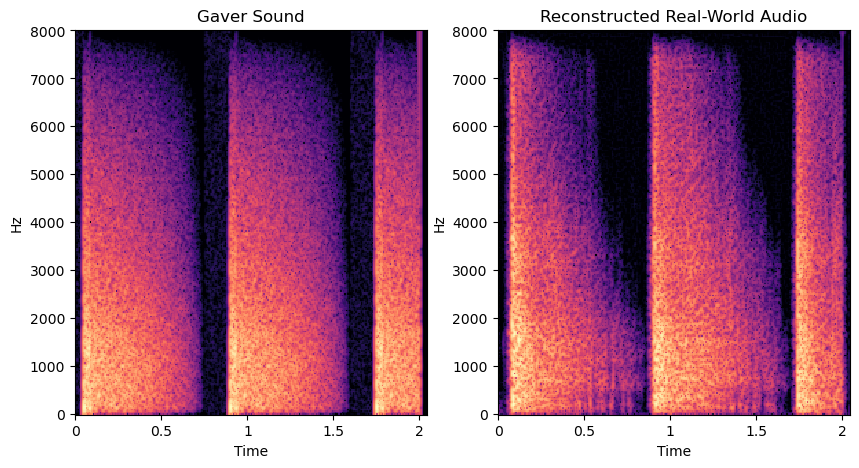

In [9]:
sample = gaver_samples_dict['scratch_muffled_sample1_rate2']
sample_encoded = torch.from_numpy(sample['encoded'].cpu().numpy()[0]).unsqueeze(dim=0).float().cuda()

sample_audio = sample['audio']
reconstructed_audio = reconstruct(sample_encoded)

util.plot_multi(sample_audio, reconstructed_audio, title1='Gaver Sound', title2='Reconstructed Real-World Audio')

# Perceived Brightness Guidance

### Bright sounds to Dull/Dark sounds

In [14]:
tinny_arr = []
muffled_arr = []
for key in gaver_samples_dict.keys(): # hit_tinny_sample0_rate0 or scratch_muffled_sample0_rate3 etc.,
    encoded = gaver_samples_dict[key]['encoded']
    if 'tinny' in key:
        tinny_arr.append(encoded.cpu().numpy()[0])
    elif 'muffled' in key:
        muffled_arr.append(encoded.cpu().numpy()[0])
        
w_avg = G.mapping.w_avg.cpu().numpy()

brightness_direction, tinny_prototype, muffled_prototype = perceptual_guidance.get_direction(tinny_arr, muffled_arr, w_avg)
brightness_direction_mag = np.linalg.norm(brightness_direction)
brightness_direction = torch.from_numpy(brightness_direction/brightness_direction_mag).float().cuda()

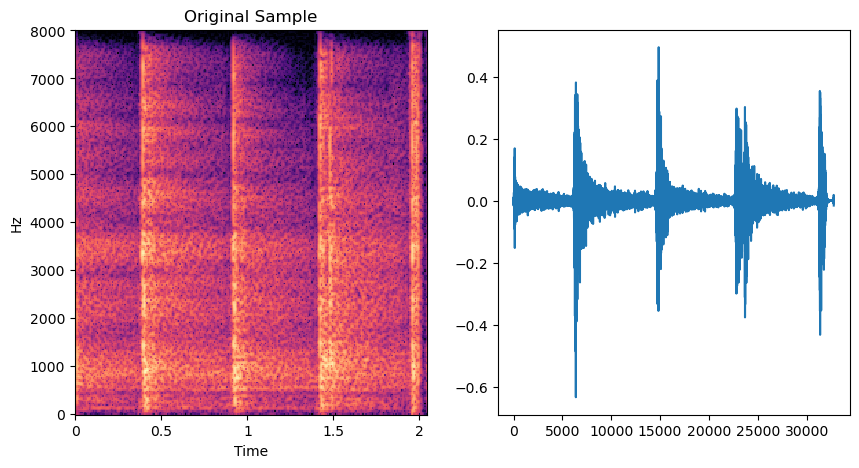

In [23]:
audio = random_sample()
util.plot(audio, title="Original Sample")

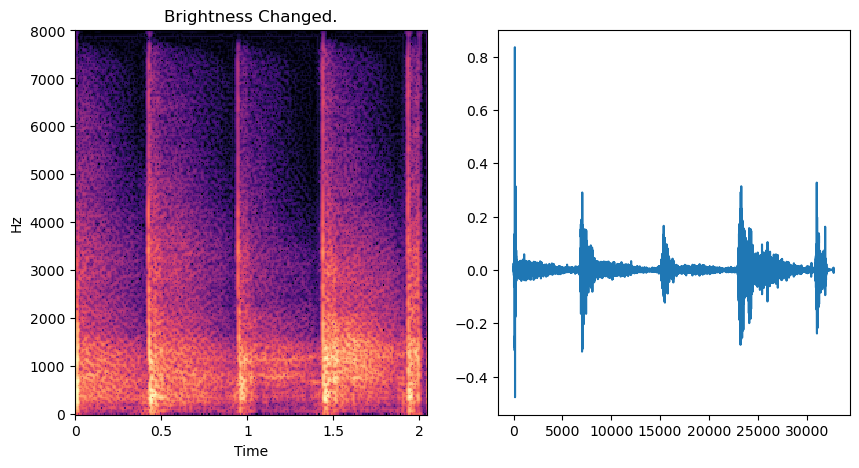

In [24]:
encoded, _ = encode_and_reconstruct(audio)

encoded = encoded - (brightness_direction * brightness_direction_mag) #Change direction. Use + for making brighter. - for muffled. 
edited_audio = reconstruct(encoded)

# Note that location of impacts and other attribute are preserved except brightness
# Use the brightness_direction_mag to control how much guidance to apply
util.plot(edited_audio, title="Brightness Changed.") 

# Impact Type Guidance

## Turn hits to scratches and vice versa

In [77]:
sharphits_arr = []
scratches_arr = []
for key in gaver_samples_dict.keys(): # hit_tinny_sample0_rate0 or scratch_muffled_sample0_rate3 etc.,
    encoded = gaver_samples_dict[key]['encoded']
    if 'hit' in key:
        sharphits_arr.append(encoded.cpu().numpy()[0])
    elif 'scratch' in key:
        scratches_arr.append(encoded.cpu().numpy()[0])
        
w_avg = G.mapping.w_avg.cpu().numpy()

impacttype_direction, hits_prototype, scratches_prototype = perceptual_guidance.get_direction(sharphits_arr, scratches_arr, w_avg)
impacttype_direction_mag = np.linalg.norm(impacttype_direction)
impacttype_direction = torch.from_numpy(impacttype_direction/impacttype_direction_mag).float().cuda()

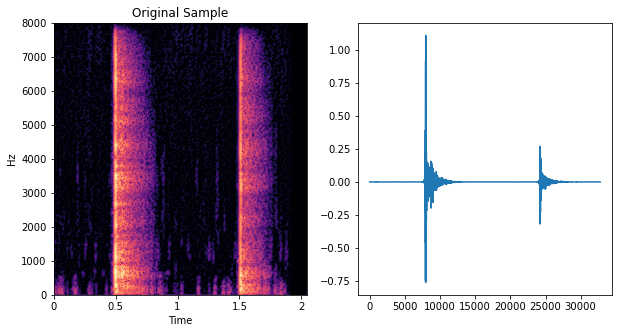

In [79]:
audio = random_sample()
util.plot(audio, title="Original Sample")

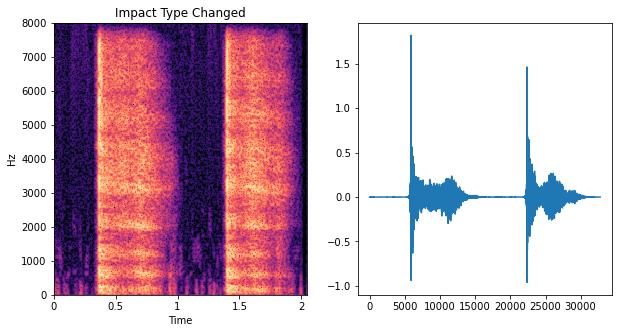

In [80]:
encoded, _ = encode_and_reconstruct(audio)

encoded = encoded - (impacttype_direction * impacttype_direction_mag) #Change direction. Use + for making sharper hits. - for more scratchiness. 
edited_audio = reconstruct(encoded)

# Note that location of impacts and other attribute are preserved except that hit turns to a scratch.
# Use the impacttype_direction_mag to control how much guidance to apply
util.plot(edited_audio, title="Impact Type Changed") 

# Rate Guidance

## Change the number of impact sounds in a sample

In [84]:
lowrate_arr = []
highrate_arr = []
for key in gaver_samples_dict.keys(): # hit_tinny_sample0_rate0 or scratch_muffled_sample0_rate3 etc.,
    encoded = gaver_samples_dict[key]['encoded']
    if 'rate0' in key:
        lowrate_arr.append(encoded.cpu().numpy()[0])
    elif 'rate3' in key:
        highrate_arr.append(encoded.cpu().numpy()[0])
        
w_avg = G.mapping.w_avg.cpu().numpy()

rate_direction, highrate_prototype, lowrate_prototype = perceptual_guidance.get_direction(highrate_arr, lowrate_arr, w_avg)
rate_direction_mag = np.linalg.norm(rate_direction)
rate_direction = torch.from_numpy(rate_direction/rate_direction_mag).float().cuda()

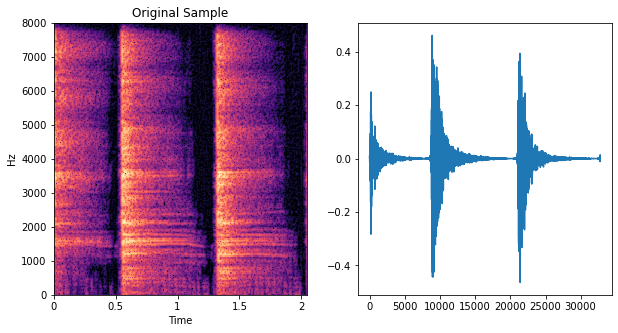

In [94]:
audio = random_sample()
util.plot(audio, title="Original Sample")

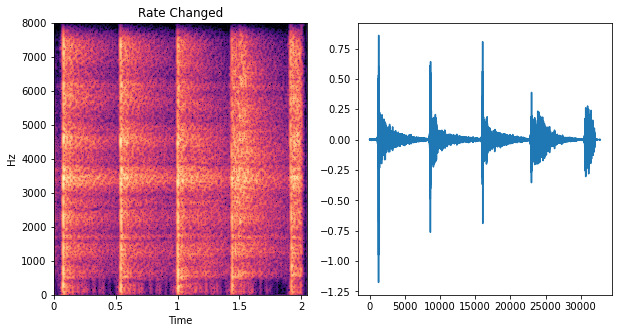

In [95]:
encoded, _ = encode_and_reconstruct(audio)

encoded = encoded + (rate_direction * rate_direction_mag) #Change direction. Use + for increasing rate. - for decreasing rate. 
edited_audio = reconstruct(encoded)

# Note that location of impacts and other attribute are preserved except that Rate.
# Use the rate_direction_mag to control how much guidance to apply
util.plot(edited_audio, title="Rate Changed")